In [1]:
import bempp.api
import os
import numpy as np
import time
from login import gmres, get_h
from operators import PMCHWT_operator, PMCHWT_preconditioner, mass_matrix_BC_SNC
bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
from IPython import embed
import multiprocessing


In [2]:
bempp.api.__version__

'3.3.4'

In [3]:
frequency = 664E9 #pick a frequency from 50, 183, 243 and 664 GHz
temperature = 200 #pick a temperature from 190, 210, 230, 250, 270 
wavelength = (3E8/frequency) 
k_ext = 2 *np.pi/wavelength

if frequency == 50E9:
    if temperature == 190:
        r = 1.7643 + 0.00042j
    elif temperature == 210:
        r = 1.7695 + 0.00051j
    elif temperature == 230:
        r = 1.7746 + 0.00064j
    elif temperature == 250:
        r = 1.7797 + 0.00084j
    elif temperature == 270:
        r = 1.7848 + 0.00120j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 183E9:
    if temperature == 190:
        r = 1.7643 + 0.00154j
    elif temperature == 210:
        r = 1.7695 + 0.00188j
    elif temperature == 230:
        r = 1.7746 + 0.00235j
    elif temperature == 250:
        r = 1.7797 + 0.00309j
    elif temperature == 270:
        r = 1.7849 + 0.00442j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 243E9:
    if temperature == 190:
        r = 1.7643 + 0.00207j
    elif temperature == 210:
        r = 1.7695 + 0.00252j
    elif temperature == 230:
        r = 1.7746 + 0.00314j
    elif temperature == 250:
        r = 1.7795 + 0.00412j
    elif temperature == 270:
        r = 1.7849 + 0.00589j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
elif frequency == 664E9:
    if temperature == 190:
        r = 1.7643 + 0.00649j
    elif temperature == 200:
        r = 1.7669+ 0.00706j
    elif temperature == 210:
        r = 1.7695 + 0.00771j
    elif temperature == 230:
        r = 1.7746 + 0.00940j
    elif temperature == 250:
        r = 1.7798 + 0.01209j
    elif temperature == 270:
        r = 1.7849 + 0.01690j
    else: raise ValueError('Temperature chosen not available for {0}GHz frequency'.format(frequency * 1E-9))
else: raise ValueError('Frequency {0}GHz not available'.format(frequency * 1E-9))
    

In [4]:
path_to_aggregate = os.getcwd() + '/refined_aggregate/'
number_of_scatterers = int(len(os.listdir(path_to_aggregate))/2)
print('Number of scatterers: {0}'.format(number_of_scatterers))

grids = []
for i in range(number_of_scatterers):
    rosette = bempp.api.import_grid(path_to_aggregate + '/hex' + str(i) + '.msh')
    grids.append(rosette)

Nelements = np.sum([np.shape(grid.leaf_view.elements)[1] for grid in grids])
print('Number of elements: {0}'.format(Nelements))

Number of scatterers: 8
Number of elements: 21368


In [5]:
processes = multiprocessing.cpu_count()
print('processors: {0}'.format(processes))

processors: 32


In [6]:
n_ind = [r] * number_of_scatterers
k_int = [k_ext * i for i in n_ind]

mu_ext = 1.0
mu_int = [1.0] * number_of_scatterers

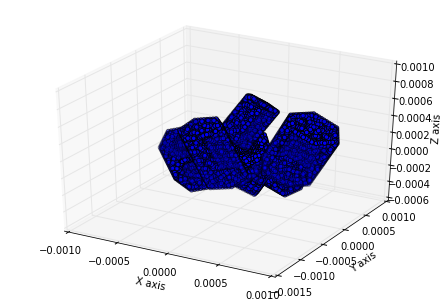

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

for i in range(number_of_scatterers):
    grid = grids[i]
    vertices = grid.leaf_view.vertices
    ax.scatter(vertices[0], vertices[1], vertices[2])

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

In [8]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_mu= [1,1,1,1]
quad_nu= [4,3,2,6]
# quad_nu = [8,8,8,8]
mu = 0.1
nu = 0.001
nf = 1

################################################
# Parameters nu

parameters_nu = global_parameters()
if nu == -1:
	parameters_nu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_nu.assembly.boundary_operator_assembly_type='hmat'
parameters_nu.hmat.eps = nu
parameters_nu.quadrature.double_singular = quad_nu[3]
parameters_nu.quadrature.far.double_order = quad_nu[2]
parameters_nu.quadrature.medium.double_order = quad_nu[1]
parameters_nu.quadrature.near.double_order = quad_nu[0]

################################################
################################################
# Parameters mu near field

parameters_mu_nf = global_parameters()
if mu == -1:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='hmat'
parameters_mu_nf.hmat.eps = mu
parameters_mu_nf.quadrature.double_singular = quad_mu[3]
parameters_mu_nf.quadrature.far.double_order = quad_mu[2]
parameters_mu_nf.quadrature.medium.double_order = quad_mu[1]
parameters_mu_nf.quadrature.near.double_order = quad_mu[0]
parameters_mu_nf.hmat.cutoff = nf

In [9]:
# Set spaces
rwg_space = [bempp.api.function_space(grid, 'RWG', 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, 'SNC', 0) for grid in grids]
bc_space = [bempp.api.function_space(grid, 'BC', 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, 'RBC', 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

[PMCHWT_op, filter_operators] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_nu)
PMCHWT_pre = PMCHWT_preconditioner(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_mu_nf)
mass_matrix = mass_matrix_BC_SNC(grids)

t0 = time.time()
pre_sf = PMCHWT_pre.strong_form()
op_wf = PMCHWT_op.weak_form()
cald_op_sf = pre_sf * mass_matrix * op_wf
ta_cald_op_sf = time.time() - t0
print('assembly time: {0} mins'.format(ta_cald_op_sf/60))

assembly time: 7.741749421755473 mins


In [10]:
restart = 200
maxiter = 400
tol=1E-5

In [11]:
n_averaging = 23 #for a list of available point see files in PointDistFiles/lebedev
if n_averaging <10:
    coord = np.loadtxt('PointDistFiles/lebedev/lebedev_00{0}.txt'.format(n_averaging))
else:
    coord = np.loadtxt('PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_averaging))
w_averaging = coord[:,2] #weights
print('Number of waves: {0}'.format(np.shape(w_averaging)[0]))
phi_averaging = np.radians(coord[:,0]) #phi
theta_averaging = np.radians(coord[:,1])#theta

Number of waves: 194


In [12]:
number_of_angles = 1801

n_leb = 59
coord = np.loadtxt('PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_leb))
w_leb = coord[:,2] #weights
phi_leb = np.radians(coord[:,0]) #phi
theta_leb = np.radians(coord[:,1])#theta


In [13]:
def incident_wave_func(counter):
    print(counter)
    weights = w_averaging[counter]
    theta_inc = theta_averaging[counter]
    phi_inc = phi_averaging[counter]

    incident_direction = np.array([np.sin(theta_inc) * np.cos(phi_inc), 
                                   np.sin(theta_inc) * np.sin(phi_inc), 
                                    np.cos(theta_inc)])
    vector_theta_inc = np.array([np.cos(theta_inc) * np.cos(phi_inc), 
                                 np.cos(theta_inc) * np.sin(phi_inc), 
                                 -np.sin(theta_inc)])
    vector_phi_inc = np.array([-np.sin(phi_inc), np.cos(phi_inc), 0])


    def plane_wave_phi(point):
        return vector_phi_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_theta(point):
        return vector_theta_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def dirichlet_trace_phi_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_phi(point), n)

    def dirichlet_trace_theta_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_theta(point), n)

    def plane_wave_curl_phi(point):
        return np.cross(incident_direction, vector_phi_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_curl_theta(point):
        return np.cross(incident_direction, vector_theta_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def neumann_trace_phi_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_phi(point), n)

    def neumann_trace_theta_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_theta(point), n)
    ##########################
    # sovling for incident field
    ##########################
    incident_dirichlet_phi = []
    incident_neumann_phi = []
    incident_dirichlet_theta = []
    incident_neumann_theta = []

    for i in range(number_of_scatterers):
        incident_dirichlet_phi.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_phi_inc))
        incident_neumann_phi.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_phi_inc))

        incident_dirichlet_theta.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_theta_inc))
        incident_neumann_theta.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_theta_inc))

    # Set RHS
    rhs_phi = number_of_scatterers * [None]
    rhs_theta = number_of_scatterers * [None]

    for i in range(number_of_scatterers):
        filter_op_wf = filter_operators[i].weak_form()
        rhs_phi[i] = filter_op_wf * (incident_dirichlet_phi[i].coefficients.tolist()+ incident_neumann_phi[i].coefficients.tolist())
        rhs_theta[i] = filter_op_wf * (incident_dirichlet_theta[i].coefficients.tolist() + incident_neumann_theta[i].coefficients.tolist())

    rhs_phi = [y for x in rhs_phi for y in x]
    rhs_theta = [y for x in rhs_theta for y in x]

    rhs_phi = pre_sf * mass_matrix * rhs_phi
    rhs_theta = pre_sf * mass_matrix * rhs_theta

    t0 = time.time()
    x_phi, info_phi, iters_phi = gmres(cald_op_sf, rhs_phi, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_phi = time.time() - t0
    print('{0}:  solver time phi: {1} mins \n iters phi: {2}'.format(counter,t_solve_phi/60, len(iters_phi)))
    if len(iters_phi) == maxiter:
        print('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    t0 = time.time()
    x_theta, info_theta, iters_theta = gmres(cald_op_sf, rhs_theta, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_theta = time.time() - t0
    print('{0}:  solver time theta: {1} mins \n iters theta: {2}'.format(counter,t_solve_theta/60, len(iters_theta)))
    if len(iters_theta) == maxiter:
        print('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

#     if counter == 0:
#         plt.figure()
#         plt.semilogy(iters_phi, label='residuals phi')
#         plt.semilogy(iters_theta, label = 'residuals theta')
#         plt.legend()
#         plt.show()
        
    scattered_dirichlet_exterior_phi = number_of_scatterers * [None]
    scattered_neumann_exterior_phi = number_of_scatterers * [None]

    scattered_dirichlet_exterior_theta = number_of_scatterers * [None]
    scattered_neumann_exterior_theta = number_of_scatterers * [None]

    sum_dofs = 0
    for i in range(number_of_scatterers):
        scattered_dirichlet_exterior_phi[i] = x_phi[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_phi[i] =  (mu_ext / k_ext) *  x_phi[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        scattered_dirichlet_exterior_theta[i] = x_theta[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_theta[i] =  (mu_ext / k_ext) *  x_theta[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        sum_dofs += rwg_space[i].global_dof_count

    ###################################################################################
    ## Computing Cext
    ###################################################################################
    far_field_phi = np.zeros((3, 1), dtype='complex128')
    far_field_theta = np.zeros((3, 1), dtype = 'complex128')

    incident_direction = np.array([[np.sin(theta_inc) * np.cos(phi_inc),
                                   np.sin(theta_inc) * np.sin(phi_inc),
                                   np.cos(theta_inc)]])

    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], incident_direction.T, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], incident_direction.T, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta


    
    Cext_phi = 4*np.pi/(k_ext * np.linalg.norm(vector_phi_inc)**2) * np.imag(np.dot(far_field_phi[:,0], np.conjugate(vector_phi_inc)))
    Cext_theta = 4*np.pi/(k_ext * np.linalg.norm(vector_theta_inc)**2) * np.imag(np.dot(far_field_theta[:,0],np.conjugate(vector_theta_inc)))
    Cext = 0.5* (Cext_phi + Cext_theta)
    
    ###################################################################################
    ## Computing Csca
    ###################################################################################
    coord_leb_Csca = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
                                np.sin(theta_leb)*np.sin(phi_leb), 
                                np.cos(theta_leb)])
    ff_quad_phi = np.zeros(np.shape(coord_leb_Csca), dtype='complex128')
    ff_quad_theta = np.zeros(np.shape(coord_leb_Csca), dtype = 'complex128')
    
    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_Csca, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_Csca, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
    ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

    Int_phi = 4*np.pi * np.dot(ff_quad_phi_mag,w_leb)
    Int_theta = 4*np.pi * np.dot(ff_quad_theta_mag,w_leb)# the 4*np.pi factor comes from the quadrature rule

    Csca_phi = 1/np.linalg.norm(vector_phi_inc)**2 * Int_phi
    Csca_theta = 1/np.linalg.norm(vector_theta_inc)**2 * Int_theta

    Csca = 0.5 * (Csca_phi + Csca_theta)
    w = Csca/Cext
    ##################################################################
    ## Computing g
    ##################################################################
    coord_leb_g = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
                             np.sin(theta_leb)*np.sin(phi_leb), 
                             np.cos(theta_leb)])
    ff_quad_phi = np.zeros(np.shape(coord_leb_g), dtype='complex128')
    ff_quad_theta = np.zeros(np.shape(coord_leb_g), dtype = 'complex128')
      
    R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
    R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])

    beta_matrix = np.dot(R_phi, R_theta)
    coord_leb_g = np.dot(beta_matrix, coord_leb_g)

    for i in range(number_of_scatterers):
        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_g, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_g, k_ext)

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
    ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

    Int_g_phi = 4*np.pi * np.dot(ff_quad_phi_mag * np.cos(theta_leb), w_leb)
    Int_g_theta = 4 * np.pi * np.dot(ff_quad_theta_mag * np.cos(theta_leb), w_leb)

    g = 0.5/Csca * (Int_g_phi + Int_g_theta)
    ##################################################################
    ## Computing phase matrix
    ##################################################################
    far_field_phi = np.zeros((3, number_of_angles), dtype='complex128')
    far_field_theta = np.zeros((3, number_of_angles), dtype = 'complex128')

    R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
    R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])

    angles_theta= np.linspace(0 + theta_inc, np.pi + theta_inc, number_of_angles)
    angles_phi = 0. + phi_inc


    scattering_direction = np.array([np.sin(angles_theta) * np.cos(angles_phi),
                                     np.sin(angles_theta) * np.sin(angles_phi),
                                     np.cos(angles_theta)])

    for i in range(number_of_scatterers):
        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i],scattering_direction, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i],scattering_direction, k_ext)

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    vector_theta_sca = np.array([np.cos(angles_theta)*np.cos(angles_phi),
                                np.cos(angles_theta)*np.sin(angles_phi),
                                -np.sin(angles_theta)])
    vector_phi_sca = np.array([-np.sin(angles_phi)*np.ones(number_of_angles),
                               np.cos(angles_phi)*np.ones(number_of_angles),
                               np.zeros(number_of_angles)])

    a11 = []
    a12 = []
    a21 = []
    a22 = []

    for i in range(number_of_angles):
        a11.append(np.dot(vector_theta_sca[:,i], far_field_theta[:,i]))
        a12.append(np.dot(vector_theta_sca[:,i], far_field_phi[:,i]))
        a21.append(np.dot(vector_phi_sca[:,i], far_field_theta[:,i]))
        a22.append(np.dot(vector_phi_sca[:,i], far_field_phi[:,i]))

    A11 = np.array(a11)
    A12 = np.array(a12)
    A21 = np.array(a21)
    A22 = np.array(a22)

    S11 = 0.5 * (abs(A11)**2 + abs(A12)**2 + abs(A21)**2 + abs(A22)**2)
    S12 = 0.5*(abs(A11)**2-abs(A22)**2+abs(A21)**2-abs(A12)**2)
    S13 = -np.real(A11*np.conjugate(A12)+A22*np.conjugate(A21))
    S14 = -np.imag(A11*np.conjugate(A12)-A22*np.conjugate(A21))
    S21 = 0.5*(abs(A11)**2-abs(A22)**2-abs(A21)**2+abs(A12)**2)
    S22 = 0.5*(abs(A11)**2+abs(A22)**2-abs(A21)**2-abs(A12)**2)
    S23 = -np.real(A11*np.conjugate(A12)-A22*np.conjugate(A21))
    S24 = -np.imag(A11*np.conjugate(A12)+A22*np.conjugate(A21))
    S31 = -np.real(A11*np.conjugate(A21)+A22*np.conjugate(A12))
    S32 = -np.real(A11*np.conjugate(A21)-A22*np.conjugate(A12))
    S33 = np.real(np.conjugate(A11)*A22+A12*np.conjugate(A21))
    S34 = np.imag(A11*np.conjugate(A22)+A21*np.conjugate(A12))
    S41 = -np.imag(np.conjugate(A11)*A21+np.conjugate(A12)*A22)
    S42 = -np.imag(np.conjugate(A11)*A21-np.conjugate(A12)*A22)
    S43 = np.imag(A22*np.conjugate(A11)-A12*np.conjugate(A21))
    S44 = np.real(np.conjugate(A11)*A22-A12*np.conjugate(A21))
    
    Cbsca = S11[-1] * 4 * np.pi

    return (counter, weights, theta_inc, phi_inc, len(iters_phi), len(iters_theta), t_solve_phi/60, t_solve_theta/60, 
            Cext, Csca, w, g, Cbsca, S11, S12, S13, S14, S21, S22, S23, S24, S31, S32, S33, S34, S41, S42, S43, S44)

In [14]:
from multiprocessing import Pool

if __name__ == '__main__':
    p = Pool(processes=processes)
    starttime = time.time()
    a = p.map(incident_wave_func, [counter for counter in range(np.shape(w_averaging)[0])])
    p.close()
    endtime = time.time()
    print('Total time: {0} mins'.format((endtime - starttime)/60))
    print('---------------------------------------------------------------')

0
4
2
6
8
10
12
14
16
18
20
26
30
28
22
24
32
34
36
38
42
40
44
62
50
52
48
56
58
54
46
60
34:  solver time phi: 70.61805387735367 mins 
 iters phi: 102
22:  solver time phi: 72.00653564532598 mins 
 iters phi: 103
50:  solver time phi: 72.0990607659022 mins 
 iters phi: 103
6:  solver time phi: 73.21462107102076 mins 
 iters phi: 102
32:  solver time phi: 73.5528764684995 mins 
 iters phi: 105
52:  solver time phi: 73.90296200911204 mins 
 iters phi: 104
0:  solver time phi: 73.84734553893408 mins 
 iters phi: 103
42:  solver time phi: 73.8043619076411 mins 
 iters phi: 103
12:  solver time phi: 74.14659520785014 mins 
 iters phi: 103
28:  solver time phi: 74.21663970549902 mins 
 iters phi: 103
40:  solver time phi: 74.40932216644288 mins 
 iters phi: 103
62:  solver time phi: 74.46459428071975 mins 
 iters phi: 105
60:  solver time phi: 74.65131354729334 mins 
 iters phi: 106
24:  solver time phi: 74.82449662685394 mins 
 iters phi: 104
26:  solver time phi: 74.95955522457758 mins 


 iters theta: 105
68
70
63:  solver time theta: 75.90245720942815 mins 
 iters theta: 104
31:  solver time theta: 75.84270393451055 mins 
 iters theta: 105
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
66:  solver time phi: 73.63943758408229 mins 
 iters phi: 103
70:  solver time phi: 73.60333918333053 mins 
 iters phi: 103
78:  solver time phi: 72.70477486451468 mins 
 iters phi: 103
64:  solver time phi: 75.51782723665238 mins 
 iters phi: 105
86:  solver time phi: 72.6791417837143 mins 
 iters phi: 101
74:  solver time phi: 73.73169243733088 mins 
 iters phi: 104
72:  solver time phi: 74.40370419422786 mins 
 iters phi: 105
68:  solver time phi: 76.87969117164612 mins 
 iters phi: 106
96:  solver time phi: 73.72620548009873 mins 
 iters phi: 103
80:  solver time phi: 74.78898332118987 mins 
 iters phi: 103
82:  solver time phi: 74.67727965116501 mins 
 iters phi: 103
94:  solver time phi: 74.34677901268006 mins 
 iters phi: 102
98:

 iters theta: 106
132
109:  solver time theta: 74.9458380540212 mins 
 iters theta: 105
113:  solver time theta: 75.17372140089671 mins 
 iters theta: 105
134
117:  solver time theta: 73.95788897673289 mins 
 iters theta: 103
125:  solver time theta: 74.33924446503322 mins 
 iters theta: 104
136
138
140
142
144
146
148
103:  solver time theta: 75.92355943123499 mins 
 iters theta: 105
150
152
154
156
158
160
162
164
166
168
170
172
127:  solver time theta: 72.36071302493413 mins 
 iters theta: 104
174
176
178
180
182
184
186
188
190
128:  solver time phi: 75.56955728530883 mins 
 iters phi: 106
130:  solver time phi: 73.94100290139517 mins 
 iters phi: 104
142:  solver time phi: 71.94446087280909 mins 
 iters phi: 101
132:  solver time phi: 73.48310987154643 mins 
 iters phi: 103
138:  solver time phi: 72.97805449962615 mins 
 iters phi: 103
134:  solver time phi: 73.48432678778967 mins 
 iters phi: 104
144:  solver time phi: 73.31068866252899 mins 
 iters phi: 102
136:  solver time ph

 iters theta: 105
181:  solver time theta: 74.64606531858445 mins 
 iters theta: 103
161:  solver time theta: 74.52328199545542 mins 
 iters theta: 105
179:  solver time theta: 75.64346477588018 mins 
 iters theta: 105
157:  solver time theta: 75.27587204376856 mins 
 iters theta: 105
187:  solver time theta: 75.31046895980835 mins 
 iters theta: 105
185:  solver time theta: 74.81222588221232 mins 
 iters theta: 105
183:  solver time theta: 74.52701982259751 mins 
 iters theta: 105
173:  solver time theta: 75.42013335227966 mins 
 iters theta: 105
191:  solver time theta: 73.05086175203323 mins 
 iters theta: 104
189:  solver time theta: 73.87047358353932 mins 
 iters theta: 104
171:  solver time theta: 74.46461192766826 mins 
 iters theta: 106
192:  solver time phi: 28.986518351236978 mins 
 iters phi: 105
192:  solver time theta: 25.761326865355173 mins 
 iters theta: 103
193
193:  solver time phi: 26.779019089539847 mins 
 iters phi: 105
193:  solver time theta: 26.824143691857657 m

In [15]:
a.sort()
w_averaging = [r[1] for r in a]
theta_inc = [r[2] for r in a]
phi_inc = [r[3] for r in a]
iterations_theta = [r[5] for r in a]
iterations_phi = [r[4] for r in a]
solver_time_phi = [r[6] for r in a]
solver_time_theta = [r[7] for r in a]
Cext = [r[8] for r in a]
Csca = [r[9] for r in a]
w = [r[10] for r in a]
g = [r[11] for r in a]
Cbsca = [r[12] for r in a]
S11 = [r[13] for r in a]
S12 = [r[14] for r in a]
S13 = [r[15] for r in a]
S14 = [r[16] for r in a]
S21 = [r[17] for r in a]
S22 = [r[18] for r in a]
S23 = [r[19] for r in a]
S24 = [r[20] for r in a]
S31 = [r[21] for r in a]
S32 = [r[22] for r in a]
S33 = [r[23] for r in a]
S34 = [r[24] for r in a]
S41 = [r[25] for r in a]
S42 = [r[26] for r in a]
S43 = [r[27] for r in a]
S44 = [r[28] for r in a]

In [16]:
path_to_results = os.getcwd() + '/results/'
path_to_result = path_to_results +  'temperature' + str(int(temperature)) + '/' + str(int(frequency *1E-9)) + 'GHz'

if not os.path.exists(path_to_result):
    os.makedirs(path_to_result)

Cext_avg = np.dot(Cext, w_averaging)
Csca_avg = np.dot(Csca, w_averaging)
Cbsca_avg = np.dot(Cbsca, w_averaging)
g_avg = np.dot(g, w_averaging)
w_avg = np.dot(w, w_averaging)

In [17]:
print('Cext: {0}'.format(Cext_avg))
print('Csca: {0}'.format(Csca_avg))
print('Cbsca: {0}'.format(Cbsca_avg))
print('g: {0}'.format(g_avg))
print('w0: {0}'.format(w_avg))
print(Csca_avg/Cext_avg)

Cext: 3.333962262606071e-06
Csca: 3.112383483402676e-06
Cbsca: 1.7582868785748686e-06
g: 0.595334232369599
w0: 0.9323384347186465
0.933538906037


In [18]:
outF = open(path_to_result + '/timings.txt','w')
outF.write('number of elements: {0}'.format(Nelements))
outF.write('\n')
outF.write('number of scatterers: {0}'.format(number_of_scatterers))
outF.write('\n')
outF.write('number of waves: {0}'.format(np.shape(w_averaging)[0]))
outF.write('\n')
outF.write('assembly time (mins): {0}'.format(ta_cald_op_sf/60))
outF.write('\n')
outF.write('solver time phi (mins): {0}'.format(solver_time_phi))
outF.write('\n')
outF.write('solver time theta (mins): {0}'.format(solver_time_theta))
outF.write('\n')
outF.write('Iterations phi: {0}'.format(iterations_phi))
outF.write('\n')
outF.write('Iterations theta: {0}'.format(iterations_theta))
outF.write('\n')
outF.write('Total parallel time (mins): {0}'.format((endtime - starttime)/60))
outF.write('\n')
outF.write('number of processors: {0}'.format(processes))
outF.write('\n')
outF.write('Cext: {0}'.format(Cext))
outF.write('\n')
outF.write('Csca: {0}'.format(Csca))
outF.write('\n')
outF.write('Cbsca: {0}'.format(Cbsca))
outF.write('\n')
outF.write('g: {0}'.format(g))
outF.write('\n')
outF.write('w: {0}'.format(w))
outF.write('\n')
outF.write('Cext avg: {0}'.format(Cext_avg))
outF.write('\n')
outF.write('Csca avg: {0}'.format(Csca_avg))
outF.write('\n')
outF.write('Cbsca avg: {0}'.format(Cbsca_avg))
outF.write('\n')
outF.write('g avg: {0}'.format(g_avg))
outF.write('\n')
outF.write('w avg: {0}'.format(w_avg))
outF.write('\n')
outF.close()

In [19]:
S11 = np.reshape(S11, (len(w_averaging), number_of_angles))
S12 = np.reshape(S12, (len(w_averaging), number_of_angles))
S13 = np.reshape(S13, (len(w_averaging), number_of_angles))
S14 = np.reshape(S14, (len(w_averaging), number_of_angles))
S21 = np.reshape(S21, (len(w_averaging), number_of_angles))
S22 = np.reshape(S22, (len(w_averaging), number_of_angles))
S23 = np.reshape(S23, (len(w_averaging), number_of_angles))
S24 = np.reshape(S24, (len(w_averaging), number_of_angles))
S31 = np.reshape(S31, (len(w_averaging), number_of_angles))
S32 = np.reshape(S32, (len(w_averaging), number_of_angles))
S33 = np.reshape(S33, (len(w_averaging), number_of_angles))
S34 = np.reshape(S34, (len(w_averaging), number_of_angles))
S41 = np.reshape(S41, (len(w_averaging), number_of_angles))
S42 = np.reshape(S42, (len(w_averaging), number_of_angles))
S43 = np.reshape(S43, (len(w_averaging), number_of_angles))
S44 = np.reshape(S44, (len(w_averaging), number_of_angles))

In [20]:
s11 = []
s12 = []
s13 = []
s14 = []
s21 = []
s22 = []
s23 = []
s24 = []
s31 = []
s32 = []
s33 = []
s34 = []
s41 = []
s42 = []
s43 = []
s44 = []
for i in range(np.shape(S11)[1]):
    s11.append(np.dot(S11[:,i], w_averaging))
    s12.append(np.dot(S12[:,i], w_averaging))
    s13.append(np.dot(S13[:,i], w_averaging))
    s14.append(np.dot(S14[:,i], w_averaging))
    s21.append(np.dot(S21[:,i], w_averaging))
    s22.append(np.dot(S22[:,i], w_averaging))
    s23.append(np.dot(S23[:,i], w_averaging))
    s24.append(np.dot(S24[:,i], w_averaging))
    s31.append(np.dot(S31[:,i], w_averaging))
    s32.append(np.dot(S32[:,i], w_averaging))
    s33.append(np.dot(S33[:,i], w_averaging))
    s34.append(np.dot(S34[:,i], w_averaging))
    s41.append(np.dot(S41[:,i], w_averaging))
    s42.append(np.dot(S42[:,i], w_averaging))
    s43.append(np.dot(S43[:,i], w_averaging))
    s44.append(np.dot(S44[:,i], w_averaging))
    
s11 = np.array(s11)
s12 = np.array(s12)
s13 = np.array(s13)
s14 = np.array(s14)
s21 = np.array(s21)
s22 = np.array(s22)
s23 = np.array(s23)
s24 = np.array(s24)
s31 = np.array(s31)
s32 = np.array(s32)
s33 = np.array(s33)
s34 = np.array(s34)
s41 = np.array(s41)
s42 = np.array(s42)
s43 = np.array(s43)
s44 = np.array(s44)


In [21]:
np.savetxt(path_to_result + '/S11.txt', s11, fmt="%e")
np.savetxt(path_to_result + '/S12.txt', s12, fmt="%e")
np.savetxt(path_to_result + '/S21.txt', s21, fmt="%e")
np.savetxt(path_to_result + '/S22.txt', s22, fmt="%e")
np.savetxt(path_to_result + '/S33.txt', s33, fmt="%e")
np.savetxt(path_to_result + '/S34.txt', s34, fmt="%e")
np.savetxt(path_to_result + '/S43.txt', s43, fmt="%e")
np.savetxt(path_to_result + '/S44.txt', s44, fmt="%e")